In [54]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches


from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lazypredict.Supervised import LazyClassifier

from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, balanced_accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer

import time

import warnings
warnings.filterwarnings('ignore')
# Read the data from CSV file
data = pd.read_csv("train.csv")

# Get basic information about the data
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80692 entries, 0 to 80691
Data columns (total 26 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   passenger_unique_identifier                      80692 non-null  float64
 1   driver_unique_identifier                         71166 non-null  float64
 2   approximate_distance_meter                       80692 non-null  int64  
 3   final_price                                      80692 non-null  float64
 4   waiting_time_enabled                             80692 non-null  int64  
 5   second_destination_final_price                   80692 non-null  float64
 6   round_ride_final_price                           80692 non-null  float64
 7   for_friend_enabled                               80692 non-null  int64  
 8   is_voucher_used                                  0 non-null      float64
 9   intercity                   

## Find Columns with Missing Values in Data

In [2]:
# Check for missing values
print("Missing values summary:")
print(data.isnull().sum())

Missing values summary:
passenger_unique_identifier                            0
driver_unique_identifier                            9526
approximate_distance_meter                             0
final_price                                            0
waiting_time_enabled                                   0
second_destination_final_price                         0
round_ride_final_price                                 0
for_friend_enabled                                     0
is_voucher_used                                    80692
intercity                                              0
request_datetime                                       0
origin_latitude                                        0
origin_longitude                                       0
destination_latitude                                   0
destination_longitude                                  0
second_destination_latitude                            0
second_destination_longitude                           0
request

In [3]:
(data.isnull().sum()/(len(data)))*100

passenger_unique_identifier                         0.00
driver_unique_identifier                           11.81
approximate_distance_meter                          0.00
final_price                                         0.00
waiting_time_enabled                                0.00
second_destination_final_price                      0.00
round_ride_final_price                              0.00
for_friend_enabled                                  0.00
is_voucher_used                                   100.00
intercity                                           0.00
request_datetime                                    0.00
origin_latitude                                     0.00
origin_longitude                                    0.00
destination_latitude                                0.00
destination_longitude                               0.00
second_destination_latitude                         0.00
second_destination_longitude                        0.00
requested_service_type         

In [4]:
data.treatment_group.value_counts()

treatment_group
A    70386
B      780
Name: count, dtype: int64

In [5]:
data.loc[data.treatment_group == "A", "ride (target)"].value_counts()

ride (target)
1    56589
0    13797
Name: count, dtype: int64

In [6]:
data['treatment_group'].fillna(data['treatment_group'].mode()[0], inplace=True)

## Find Duplicate Records in Data

In [7]:
data.duplicated().sum()

0

## Rename Target Columns in Data for more Convenient Data Manipulation

In [8]:
data = data.rename(columns = {"ride (target)":"target"})

## Drop Useless Columns

In [9]:
data = data.drop(["('new_origin_latitude', 'new_origin_longitude')", "is_voucher_used",
                                                  "driver_unique_identifier", "passenger_unique_identifier"], axis="columns")

## Drop Rows with Missing Data

In [10]:
data = data.dropna()

In [11]:
data['request_datetime'] = pd.to_datetime(data['request_datetime'])

## Convert Column Containing Date to DateTime

In [12]:
# Analyze data types
print("Data types:")
print(data.dtypes)

Data types:
approximate_distance_meter                                int64
final_price                                             float64
waiting_time_enabled                                      int64
second_destination_final_price                          float64
round_ride_final_price                                  float64
for_friend_enabled                                        int64
intercity                                                 int64
request_datetime                      datetime64[ns, UTC+03:30]
origin_latitude                                         float64
origin_longitude                                        float64
destination_latitude                                    float64
destination_longitude                                   float64
second_destination_latitude                             float64
second_destination_longitude                            float64
requested_service_type                                   object
days_since_passenger_first_r

## Investigate Unique Values of Features to Decide if they should be converted to Categorical Type

In [13]:
data.nunique()

approximate_distance_meter            14341
final_price                             430
waiting_time_enabled                      2
second_destination_final_price         1878
round_ride_final_price                  706
for_friend_enabled                        2
intercity                                 2
request_datetime                      75692
origin_latitude                        8479
origin_longitude                       8479
destination_latitude                   8479
destination_longitude                  8479
second_destination_latitude            8479
second_destination_longitude           8479
requested_service_type                    5
days_since_passenger_first_ride        2394
days_since_passenger_first_request     2405
in_hurry_enabled                          4
target                                    2
treatment_group                           2
new_origin_latitude                   80692
new_origin_longitude                  80692
dtype: int64

## Binarize the featuer "in_hurry_enabled"

In [14]:
data.in_hurry_enabled.unique()

array([0, 1, 2, 3], dtype=int64)

In [15]:
encode={'in_hurry_enabled':{0:0, 1:1, 2:1, 3:1}}
data = data.replace(encode)

In [16]:
data.nunique()

approximate_distance_meter            14341
final_price                             430
waiting_time_enabled                      2
second_destination_final_price         1878
round_ride_final_price                  706
for_friend_enabled                        2
intercity                                 2
request_datetime                      75692
origin_latitude                        8479
origin_longitude                       8479
destination_latitude                   8479
destination_longitude                  8479
second_destination_latitude            8479
second_destination_longitude           8479
requested_service_type                    5
days_since_passenger_first_ride        2394
days_since_passenger_first_request     2405
in_hurry_enabled                          2
target                                    2
treatment_group                           2
new_origin_latitude                   80692
new_origin_longitude                  80692
dtype: int64

## Compute Price per Meter

In [17]:
data["price_per_meter"] = data.apply(lambda df: 0 if df["approximate_distance_meter"] == 0
                                                                                 else df["final_price"]/df["approximate_distance_meter"], axis=1)

## Deep Learning

In [18]:
def date_info_extractor(data, column):
    data.loc[:, 'request_hour'] = data[column].dt.hour
    data.loc[:, 'request_weekday'] = data[column].dt.day_name()
    data.loc[:, 'request_date'] = data[column].dt.day

    return data

data = date_info_extractor(data.copy(), "request_datetime")

data = data.drop(["origin_longitude", "destination_longitude", "second_destination_longitude",
                  "origin_latitude", "destination_latitude", "second_destination_latitude", "request_datetime"], axis="columns")

In [19]:
data.nunique()

approximate_distance_meter            14341
final_price                             430
waiting_time_enabled                      2
second_destination_final_price         1878
round_ride_final_price                  706
for_friend_enabled                        2
intercity                                 2
requested_service_type                    5
days_since_passenger_first_ride        2394
days_since_passenger_first_request     2405
in_hurry_enabled                          2
target                                    2
treatment_group                           2
new_origin_latitude                   80692
new_origin_longitude                  80692
price_per_meter                       61974
request_hour                             24
request_weekday                           7
request_date                             10
dtype: int64

In [20]:
X = data.copy()
y = X.pop('target')

features_num = [
    "approximate_distance_meter", "final_price",
    "second_destination_final_price", "round_ride_final_price",
    "days_since_passenger_first_ride", "days_since_passenger_first_request",
    "new_origin_latitude", "new_origin_longitude", "price_per_meter",
]
features_cat = [
    "waiting_time_enabled", "for_friend_enabled", "intercity",
    "requested_service_type", "in_hurry_enabled",
    "request_weekday", "request_hour", "request_date",
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="most_frequent"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown='ignore', sparse=False),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.8)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]

In [21]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.BatchNormalization(input_shape = input_shape),
    layers.Dense(128, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation = 'relu'),
    layers.BatchNormalization(),
    # layers.Dropout(0.3),
    # layers.Dense(64, activation = 'relu'),
    # layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation = 'sigmoid')
])


In [22]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = METRICS
)

Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - Brier score: 0.2425 - accuracy: 0.6535 - auc: 0.6419 - cross entropy: 0.7553 - fn: 5548.0625 - fp: 4761.8438 - loss: 0.7553 - prc: 0.7760 - precision: 0.7782 - recall: 0.7123 - tn: 4837.9062 - tp: 17864.8281 - val_Brier score: 0.1445 - val_accuracy: 0.8183 - val_auc: 0.7375 - val_cross entropy: 0.4533 - val_fn: 9.0000 - val_fp: 2924.0000 - val_loss: 0.4533 - val_prc: 0.8335 - val_precision: 0.7963 - val_recall: 0.9992 - val_tn: 1777.0000 - val_tp: 11429.0000
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 0.1532 - accuracy: 0.8070 - auc: 0.7213 - cross entropy: 0.4855 - fn: 728.5312 - fp: 5571.9688 - loss: 0.4855 - prc: 0.8198 - precision: 0.8026 - recall: 0.9653 - tn: 4019.8828 - tp: 22692.2578 - val_Brier score: 0.1437 - val_accuracy: 0.8185 - val_auc: 0.7409 - val_cross entropy: 0.4506 - val_fn: 10.0000 - val_fp: 2919.0000 - val_loss: 0.4506 - val_prc: 0.8378 - val_precision: 0.7965 - val_recall: 0.9991 - val

<Axes: title={'center': 'Cross-entropy'}>

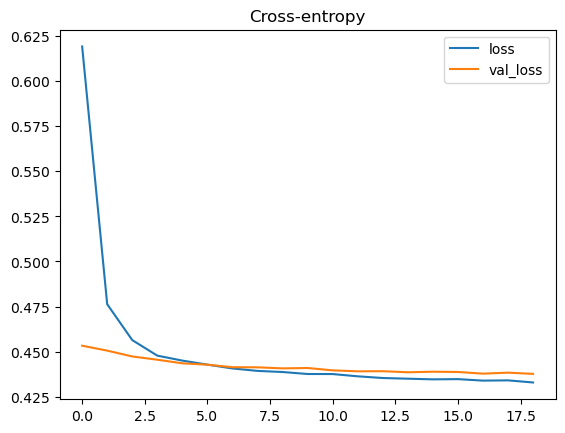

In [23]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
# history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [24]:
neg, pos = np.bincount(data['target'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 80692
    Positive: 57186 (70.87% of total)



In [25]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
    # layers.BatchNormalization(input_shape = [X_train.shape[1]]),
    layers.Dense(4, activation = 'relu',
                          input_shape = [X_train.shape[1]]),
    # layers.BatchNormalization(),
    # layers.Dropout(0.5),
    # layers.Dense(64, activation = 'relu'),
    # layers.BatchNormalization(),
    # # layers.Dropout(0.3),
    # # layers.Dense(64, activation = 'relu'),
    # # layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation = 'sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [26]:
import tensorflow as tf

In [27]:
EPOCHS = 100
BATCH_SIZE = 512

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [28]:
model = make_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 4)              │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 261 (1.02 KB)

 Trainable params: 261 (1.02 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.predict(X_train[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


array([[0.32146233],
       [0.4253243 ],
       [0.34032163],
       [0.35277596],
       [0.45614967],
       [0.39473602],
       [0.2567847 ],
       [0.34565318],
       [0.32694915],
       [0.4076063 ]], dtype=float32)

In [30]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.8401


In [31]:
initial_bias = np.log([pos/neg])
initial_bias

array([0.88905341])

In [32]:
model = make_model(output_bias=initial_bias)
model.predict(X_train[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([[0.7049149 ],
       [0.7359754 ],
       [0.70404047],
       [0.77491367],
       [0.75769603],
       [0.83415383],
       [0.7133368 ],
       [0.74164975],
       [0.7448379 ],
       [0.81833124]], dtype=float32)

In [33]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6026


In [34]:
import os
import tempfile

In [35]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights.weights.h5')
model.save_weights(initial_weights)

In [36]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_valid, y_valid),
    verbose=0)

In [37]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_valid, y_valid),
    verbose=0)

In [38]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [39]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

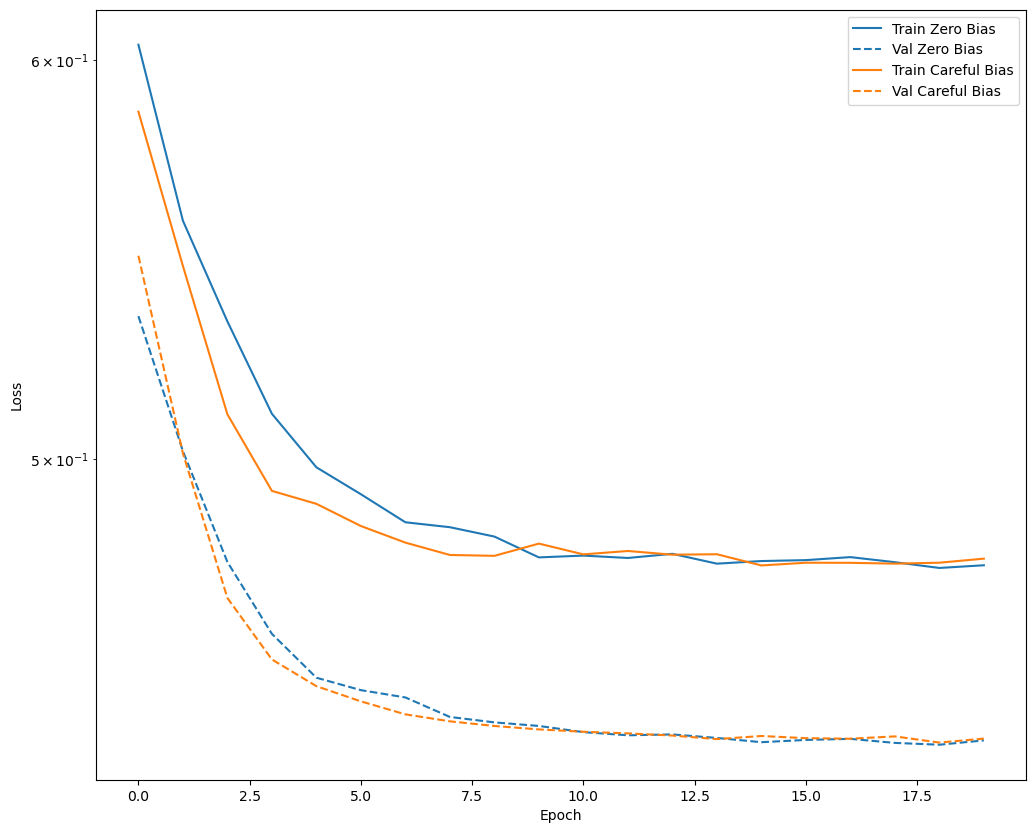

In [40]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [41]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
   X_train,
   y_train,
   batch_size=BATCH_SIZE,
   epochs=EPOCHS,
   callbacks=[early_stopping],
   validation_data=(X_valid, y_valid))

Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - Brier score: 0.1778 - accuracy: 0.7561 - auc: 0.6640 - cross entropy: 0.5357 - fn: 45.6406 - fp: 12257.8906 - loss: 0.6010 - prc: 0.7934 - precision: 0.7446 - recall: 0.9987 - tn: 2078.6406 - tp: 34769.4688 - val_Brier score: 0.1830 - val_accuracy: 0.7185 - val_auc: 0.7244 - val_cross entropy: 0.5497 - val_fn: 0.0000e+00 - val_fp: 4543.0000 - val_loss: 0.5497 - val_prc: 0.8195 - val_precision: 0.7157 - val_recall: 1.0000 - val_tn: 158.0000 - val_tp: 11438.0000
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Brier score: 0.1844 - accuracy: 0.7541 - auc: 0.6558 - cross entropy: 0.5561 - fn: 35.5625 - fp: 7991.5625 - loss: 0.5561 - prc: 0.7923 - precision: 0.7430 - recall: 0.9986 - tn: 1586.7500 - tp: 23398.7656 - val_Brier score: 0.1599 - val_accuracy: 0.8009 - val_auc: 0.7476 - val_cross entropy: 0.4997 - val_fn: 5.0000 - val_fp: 3209.0000 - val_loss: 0.4997 - val_prc: 0.8410 - val_precision: 0.7808 - val_recall: 0.9996 - val

In [42]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

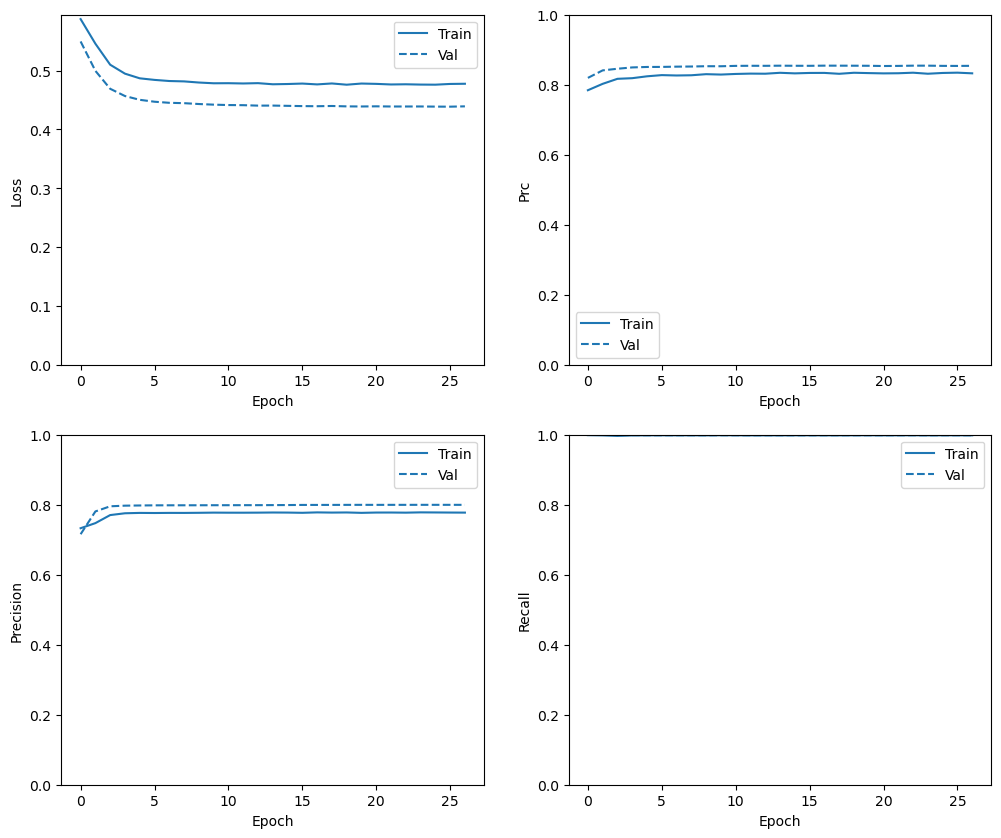

In [43]:
plot_metrics(baseline_history)

In [44]:
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
valid_predictions_baseline = model.predict(X_valid, batch_size=BATCH_SIZE)

127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


In [45]:
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Requests Not Led to Ride Detected (True Negatives): ', cm[0][0])
  print('Requests Not Led to Ride Incorrectly Detected (False Positives): ', cm[0][1])
  print('Requests Led to Ride Missed (False Negatives): ', cm[1][0])
  print('Requests Led to Ride Detected (True Positives): ', cm[1][1])
  print('Total Requests Led to Ride: ', np.sum(cm[1]))

loss :  0.4395565688610077
compile_metrics :  0.4395565688610077

Requests Not Led to Ride Detected (True Negatives):  1835
Requests Not Led to Ride Incorrectly Detected (False Positives):  2866
Requests Led to Ride Missed (False Negatives):  16
Requests Led to Ride Detected (True Positives):  11422
Total Requests Led to Ride:  11438


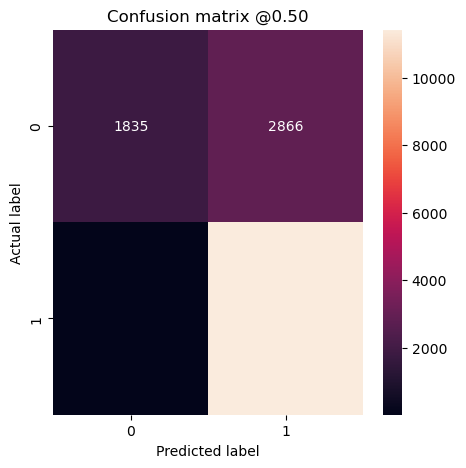

In [46]:
baseline_results = model.evaluate(X_valid, y_valid,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_valid, valid_predictions_baseline)

Requests Not Led to Ride Detected (True Negatives):  1766
Requests Not Led to Ride Incorrectly Detected (False Positives):  2935
Requests Led to Ride Missed (False Negatives):  7
Requests Led to Ride Detected (True Positives):  11431
Total Requests Led to Ride:  11438
Requests Not Led to Ride Detected (True Negatives):  1299
Requests Not Led to Ride Incorrectly Detected (False Positives):  3402
Requests Led to Ride Missed (False Negatives):  1
Requests Led to Ride Detected (True Positives):  11437
Total Requests Led to Ride:  11438


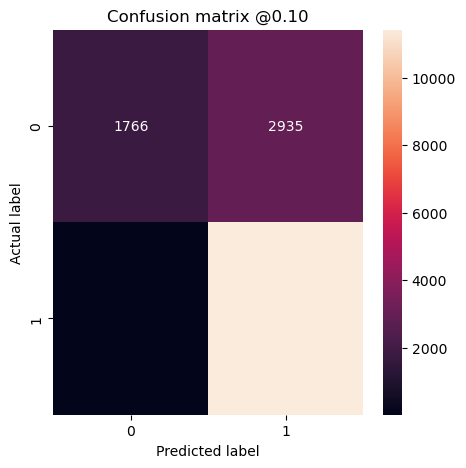

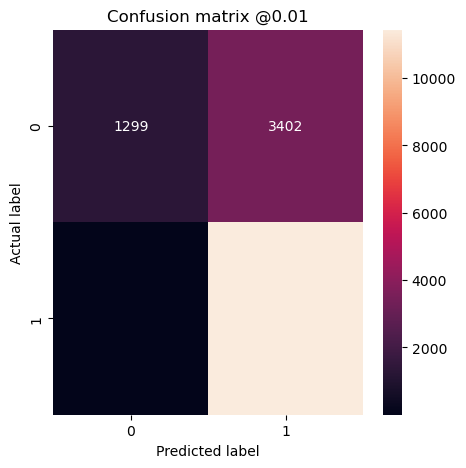

In [47]:
plot_cm(y_valid, valid_predictions_baseline, threshold=0.1)
plot_cm(y_valid, valid_predictions_baseline, threshold=0.01)

In [48]:
import sklearn

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  # plt.xlim([-0.5,20])
  # plt.ylim([60,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

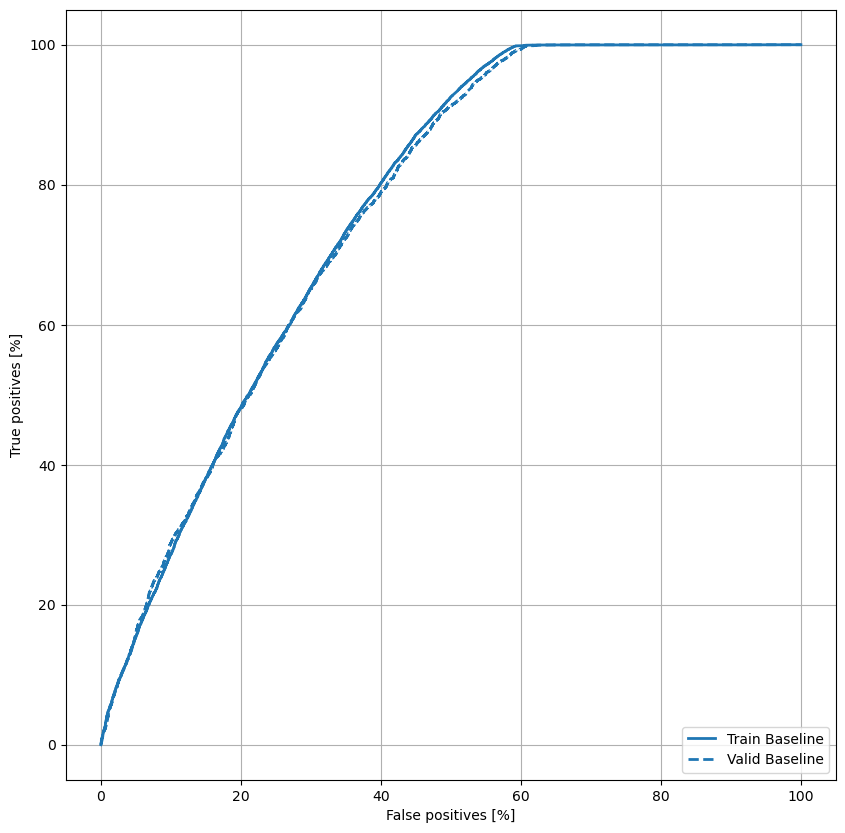

In [49]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Valid Baseline", y_valid, valid_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [50]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    # ax.set_aspect('equal')

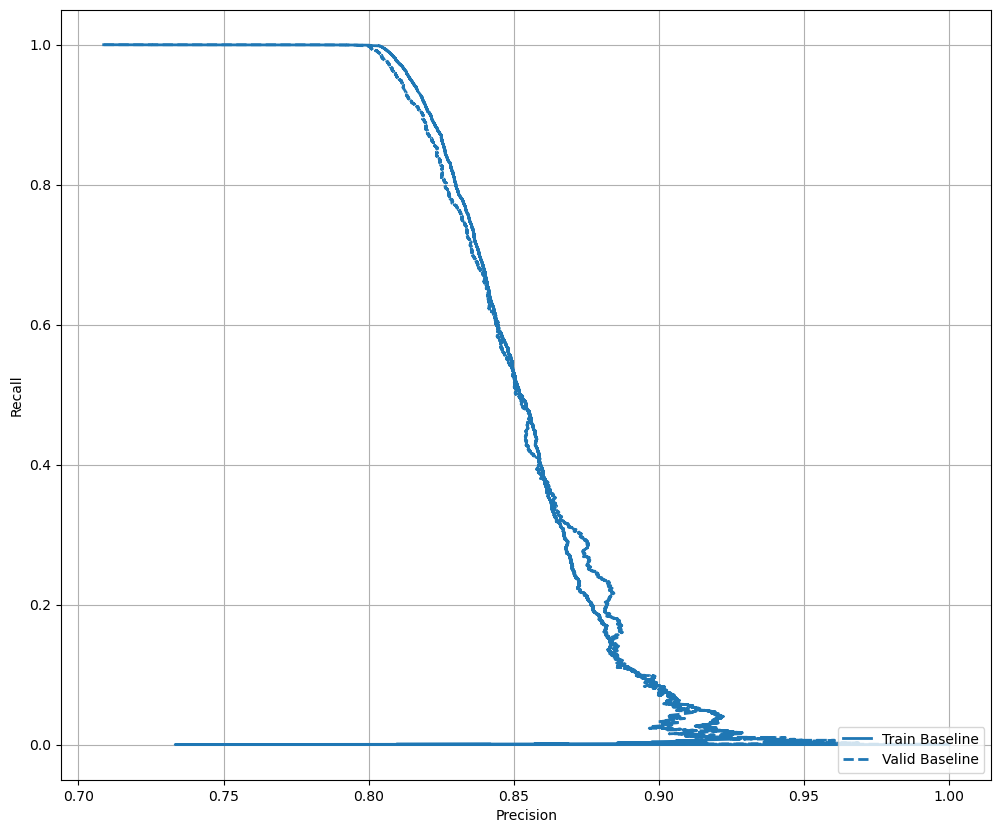

In [51]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Valid Baseline", y_valid, valid_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [52]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.72
Weight for class 1: 0.71


In [53]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_valid, y_valid),
    # The class weights go here
    class_weight=class_weight)

KeyError: 0

In [ ]:
plot_metrics(weighted_history)

In [ ]:
train_predictions_weighted = weighted_model.predict(X_train, batch_size=BATCH_SIZE)
valid_predictions_weighted = weighted_model.predict(X_valid, batch_size=BATCH_SIZE)

In [ ]:
weighted_results = weighted_model.evaluate(X_valid, y_valid,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_valid, valid_predictions_weighted)

In [ ]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Valid Baseline", y_valid, valid_predictions_weighted, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Valid Weighted", y_valid, valid_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

In [ ]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Valid Baseline", y_valid, valid_predictions_weighted, color=colors[0], linestyle='--')

plot_prc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_prc("Valid Weighted", y_valid, valid_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

In [ ]:
bool_train_labels = y_train != 0

In [ ]:
pos_features = X_train[bool_train_labels]
neg_features = X_train[~bool_train_labels]

pos_labels = y_train[bool_train_labels]
neg_labels = y_train[~bool_train_labels]

In [ ]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

## Split the Data into Train and Validation

In [ ]:
y = data.target
data.drop(['target'], axis=1, inplace=True)

X_train, X_val, y_train, y_val = train_test_split(data, y, stratify = y, test_size=.2, random_state =10)

## Extract Useful Info from Date Column

In [ ]:
def date_info_extractor(data, column):
    data.loc[:, 'request_hour'] = data[column].dt.hour
    data.loc[:, 'request_weekday'] = data[column].dt.day_name()
    data.loc[:, 'request_date'] = data[column].dt.day

    return data

X_train = date_info_extractor(X_train.copy(), "request_datetime")
X_val = date_info_extractor(X_val.copy(), "request_datetime")

In [ ]:
X_train.info()

In [ ]:
X_train.nunique()

## Find Columns with Duplicate Values in Other Columns and Dropping them

In [ ]:
data = data.drop(["origin_longitude", "destination_longitude", "second_destination_longitude",
                  "origin_latitude", "destination_latitude", "second_destination_latitude"], axis="columns")

In [ ]:
X_train = X_train.drop(["origin_longitude", "destination_longitude", "second_destination_longitude",
                  "origin_latitude", "destination_latitude", "second_destination_latitude"], axis="columns")

X_val = X_val.drop(["origin_longitude", "destination_longitude", "second_destination_longitude",
                  "origin_latitude", "destination_latitude", "second_destination_latitude"], axis="columns")

In [ ]:
X_train.info()

In [ ]:
X_train.nunique()

## Covert some Features to Categorical

In [ ]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train.columns if X_train[cname].nunique() < 25 and
                        X_train[cname].dtype in ["int64", "object","int32"]]

In [ ]:
def one_hot_encode(X_train, X_val, low_cardinality_cols):
    # Use as many lines of code as you need!
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

    OH_X_train_cols = pd.DataFrame(ohe.fit_transform(X_train[low_cardinality_cols]))
    OH_X_valid_cols = pd.DataFrame(ohe.transform(X_val[low_cardinality_cols]))

    OH_X_train_cols.index = X_train.index
    OH_X_valid_cols.index = X_val.index

    X_train_num_cols = X_train.drop(low_cardinality_cols, axis = 1)
    X_valid_num_cols = X_val.drop(low_cardinality_cols, axis = 1)

    OH_X_train = pd.concat([OH_X_train_cols, X_train_num_cols], axis = 1) # Your code here
    OH_X_valid = pd.concat([OH_X_valid_cols, X_valid_num_cols], axis = 1) # Your code here

    OH_X_train.columns = OH_X_train.columns.astype(str)
    OH_X_valid.columns = OH_X_valid.columns.astype(str)

    return OH_X_train.copy(), OH_X_valid.copy()

X_train, X_val = one_hot_encode(X_train, X_val, low_cardinality_cols)

In [ ]:
X_train.head()

In [ ]:
X_val.head()

## Investigate the Range, Mean, and Standard Deviation of Numerical Features

In [ ]:
# Descriptive statistics for numerical features
print("Descriptive statistics:")
X_train.loc[:,X_train.nunique()>24].describe().T

## Scaling the Numerical Features

In [ ]:
X_train.drop(["request_datetime"], axis=1, inplace=True)
X_val.drop(["request_datetime"], axis=1, inplace=True)

In [ ]:
uscaled_X_train = X_train.copy()
uscaled_X_val = X_val.copy()

In [ ]:
uscaled_X_train.columns

In [ ]:
print("Descriptive statistics:")
uscaled_X_train.loc[:,uscaled_X_train.nunique()>24].describe().T

In [ ]:
rob_scaler = RobustScaler()

standardable_feats = [ 'approximate_distance_meter', 'final_price', 'second_destination_final_price', 'round_ride_final_price',
                      'days_since_passenger_first_ride', 'days_since_passenger_first_request']

for col_name in standardable_feats:
    X_train["scaled_"+col_name] = rob_scaler.fit_transform(X_train[col_name].values.reshape(-1,1))
    X_val["scaled_"+col_name] = rob_scaler.transform(X_val[col_name].values.reshape(-1,1))

X_train.drop(standardable_feats, axis=1, inplace=True)
X_val.drop(standardable_feats, axis=1, inplace=True)

In [ ]:
print("Descriptive statistics:")
X_train.info()

## Fitting Models on Imbalanced Data

In [ ]:
# imbalanced_data = data.copy()

# # Label encoding for categoricals
# for colname in imbalanced_data.select_dtypes("object"):
#     imbalanced_data[colname], _ = imbalanced_data[colname].factorize()

# imbalanced_X = imbalanced_data.drop(['target', 'request_datetime'], axis=1)
# imbalanced_y = imbalanced_data['target']

# X_train, X_test, y_train, y_test = train_test_split(imbalanced_X, imbalanced_y, stratify = imbalanced_y, test_size=.25, random_state =123)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train.to_numpy(), X_val.to_numpy(), y_train, y_val)

print(models)

In [ ]:
# xgb1 = XGBClassifier(
#  learning_rate =0.1,
#  n_estimators=1000,
#  max_depth=5,
#  min_child_weight=1,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=27)

# We will undersample during cross validating
sss = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)

# undersampled_data = data.copy()
imbalanced_X_train = X_train.copy()
imbalanced_X_val = X_val.copy()

# Label encoding for categoricals
# for colname in undersampled_data.select_dtypes("object"):
#     undersampled_data[colname], _ = undersampled_data[colname].factorize()

# undersample_X = undersampled_data.drop(['target', 'request_datetime'], axis=1)
# undersample_y = undersampled_data['target']

# for train_index, test_index in sss.split(undersample_X, undersample_y):
#     print("Train:", train_index, "Test:", test_index)
#     undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
#     undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]

imbalanced_X_train = imbalanced_X_train.values
imbalanced_X_val = imbalanced_X_val.values
imbalanced_y_train = y_train.values
imbalanced_y_val = y_val.values

imbalanced_accuracy = []
imbalanced_precision = []
imbalanced_recall = []
imbalanced_f1 = []
imbalanced_auc = []
imbalanced_balanced_accuracy = []

imbalanced_val_accuracy = []
imbalanced_val_precision = []
imbalanced_val_recall = []
imbalanced_val_f1 = []
imbalanced_val_auc = []
imbalanced_val_balanced_accuracy = []

xgb_params = {
 'learning_rate' :[1e-3, 1e-2, 0.1, 0.2, 0.3],
 'n_estimators' : [10, 100, 1000, 10000],
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
 'gamma':[i/10.0 for i in range(0,5)],
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)],
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
 }

rand_xgb = RandomizedSearchCV(XGBClassifier(objective= 'binary:logistic'), xgb_params, n_iter=4)

# Implementing NearMiss Technique
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
# X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
# print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

for train, test in sss.split(imbalanced_X_train, imbalanced_y_train):
    # undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), XGBClassifier(objective= 'binary:logistic')) # SMOTE happens during Cross Validation not before..
    # undersample_model = undersample_pipeline.fit(undersample_X[train], undersample_y[train])
    # undersample_prediction = undersample_model.predict(undersample_X[test])

    imbalanced_pipeline = make_pipeline(rand_xgb) # SMOTE happens during Cross Validation not before..
    imbalanced_model = imbalanced_pipeline.fit(imbalanced_X_train[train], imbalanced_y_train[train])
    best_est = rand_xgb.best_estimator_

    imbalanced_prediction = imbalanced_model.predict(imbalanced_X_train[test])
    # imbalanced_accuracy.append(imbalanced_pipeline.score(imbalanced_X_train[test], imbalanced_y_train[test]))
    imbalanced_accuracy.append(accuracy_score(imbalanced_y_train[test], imbalanced_prediction))
    imbalanced_precision.append(precision_score(imbalanced_y_train[test], imbalanced_prediction))
    imbalanced_recall.append(recall_score(imbalanced_y_train[test], imbalanced_prediction))
    imbalanced_f1.append(f1_score(imbalanced_y_train[test], imbalanced_prediction))
    imbalanced_auc.append(roc_auc_score(imbalanced_y_train[test], imbalanced_model.predict_proba(imbalanced_X_train[test])[:, 1]))
    imbalanced_balanced_accuracy.append(balanced_accuracy_score(imbalanced_y_train[test], imbalanced_prediction))

    imbalanced_val_prediction = imbalanced_model.predict(imbalanced_X_val)
    # imbalanced_val_accuracy.append(imbalanced_pipeline.score(imbalanced_X_val, imbalanced_y_val))
    imbalanced_val_accuracy.append(accuracy_score(imbalanced_y_val, imbalanced_val_prediction))
    imbalanced_val_precision.append(precision_score(imbalanced_y_val, imbalanced_val_prediction))
    imbalanced_val_recall.append(recall_score(imbalanced_y_val, imbalanced_val_prediction))
    imbalanced_val_f1.append(f1_score(imbalanced_y_val, imbalanced_val_prediction))
    imbalanced_val_auc.append(roc_auc_score(imbalanced_y_val, imbalanced_model.predict_proba(imbalanced_X_val)[:, 1]))
    imbalanced_val_balanced_accuracy.append(balanced_accuracy_score(imbalanced_y_val, imbalanced_val_prediction))



print("Training Data Accuracy Score: {:.2f}".format(np.mean(imbalanced_accuracy)))
print("Training Data Precision Score: {:.2f}".format(np.mean(imbalanced_precision)))
print("Training Data Recall Score: {:.2f}".format(np.mean(imbalanced_recall)))
print("Training Data F1 Score: {:.2f}".format(np.mean(imbalanced_f1)))
print("Training Data ROC AUC: {:.2f}".format(np.mean(imbalanced_auc)))
print("Training Data Balanced Accuracy Score: {:.2f}".format(np.mean(imbalanced_balanced_accuracy)))
print("*"*100)
print("Validation Data Accuracy Score: {:.2f}".format(np.mean(imbalanced_val_accuracy)))
print("Validation Data Precision Score: {:.2f}".format(np.mean(imbalanced_val_precision)))
print("Validation Data Recall Score: {:.2f}".format(np.mean(imbalanced_val_recall)))
print("Validation Data F1 Score: {:.2f}".format(np.mean(imbalanced_val_f1)))
print("Validation Data ROC AUC: {:.2f}".format(np.mean(imbalanced_val_auc)))
print("Validation Data Balanced Accuracy Score: {:.2f}".format(np.mean(imbalanced_val_balanced_accuracy)))

In [ ]:
def modelfit(alg, xtrain, ytrain, X_val, y_val, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(xtrain, label=ytrain)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])

    #Fit the algorithm on the data
    # alg.fit(xtrain, ytrain,eval_metric='auc')
    alg.fit(xtrain, ytrain)

    #Predict training set:
    dtrain_predictions = alg.predict(xtrain)
    dtrain_predprob = alg.predict_proba(xtrain)[:,1]

    #Predict training set:
    dvalid_predictions = alg.predict(X_val)
    dvalid_predprob = alg.predict_proba(X_val)[:,1]

    def report_generate(ytrain, dtrain_predictions, dtrain_predprob, split_type):
        #Print model report:
        print("\nModel Report on "+split_type)
        print("Accuracy : %.4g" % accuracy_score(ytrain, dtrain_predictions))
        print("F1 Score : %.4g" % f1_score(ytrain, dtrain_predictions))
        print("Precision Score : %.4g" % precision_score(ytrain, dtrain_predictions))
        print("Recall Score : %.4g" % recall_score(ytrain, dtrain_predictions))
        print("ROC AUC Score (Train): %f" % roc_auc_score(ytrain, dtrain_predprob))
        print("Balanced Accuracy Score (Train): %f" % balanced_accuracy_score(ytrain, dtrain_predictions))


    report_generate(ytrain, dtrain_predictions, dtrain_predprob, "Training Data")
    report_generate(y_val, dvalid_predictions, dvalid_predprob, "Validation Data")

    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [ ]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
# New_df is from the random undersample data (fewer instances)
# , 'request_datetime',
#                     'passenger_unique_identifier', 'driver_unique_identifier'
# X_train = data.drop(['target','request_datetime'], axis=1)
# y_train = data['target']

modelfit(xgb1, X_train.to_numpy(), y_train, X_val.to_numpy(), y_val)

In [ ]:
# USING UNSCALED DATA
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
# New_df is from the random undersample data (fewer instances)
# , 'request_datetime',
#                     'passenger_unique_identifier', 'driver_unique_identifier'

# temp_unscaled_data = uscaled_data.copy()

# # Label encoding for categoricals
# for colname in temp_unscaled_data.select_dtypes("object"):
#     temp_unscaled_data[colname], _ = temp_unscaled_data[colname].factorize()

# # All discrete features should now have integer dtypes (double-check this before using MI!)
# discrete_features = temp_unscaled_data.dtypes == int
# X_train = temp_unscaled_data.drop(['target','request_datetime'], axis=1)
# y_train = temp_unscaled_data['target']

# uscaled_X_train = uscaled_X_train.drop(['request_datetime'], axis=1)
# uscaled_X_val = uscaled_X_val.drop(['request_datetime'], axis=1)

# uscaled_X_train.drop(["request_datetime"], axis=1, inplace=True)
# uscaled_X_val.drop(["request_datetime"], axis=1, inplace=True)

modelfit(xgb1, uscaled_X_train.to_numpy(), y_train, uscaled_X_val.to_numpy(), y_val)

## Use Undersampling to Deal with Imbalanced Dataset

In [ ]:
undersampled_data = data.copy()

# # Label encoding for categoricals
# for colname in undersampled_data.select_dtypes("object"):
#     undersampled_data[colname], _ = undersampled_data[colname].factorize()

# undersample_X = undersampled_data.drop(['target', 'request_datetime'], axis=1)
# undersample_y = undersampled_data['target']

# for train_index, test_index in sss.split(undersample_X, undersample_y):
#     print("Train:", train_index, "Test:", test_index)
#     undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
#     undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]

# Implementing NearMiss Technique
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
nm = NearMiss(sampling_strategy='majority')
X_train_nearmiss, y_train_nearmiss = nm.fit_resample(X_train.values, y_train.values)
X_val_nearmiss, y_val_nearmiss = nm.fit_resample(X_val.values, y_val.values)

# print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way
# X_train, X_test, y_train, y_test = train_test_split(X_nearmiss, y_nearmiss, stratify = y_nearmiss, test_size=.25, random_state =123)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_nearmiss, X_val_nearmiss, y_train_nearmiss, y_val_nearmiss)

print(models)

In [ ]:
# xgb1 = XGBClassifier(
#  learning_rate =0.1,
#  n_estimators=1000,
#  max_depth=5,
#  min_child_weight=1,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=27)

# We will undersample during cross validating
# sss = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)

# undersampled_data = data.copy()
undersampled_X_train = X_train.copy()
undersampled_X_val = X_val.copy()

# Label encoding for categoricals
# for colname in undersampled_data.select_dtypes("object"):
#     undersampled_data[colname], _ = undersampled_data[colname].factorize()

# undersample_X = undersampled_data.drop(['target', 'request_datetime'], axis=1)
# undersample_y = undersampled_data['target']

# for train_index, test_index in sss.split(undersample_X, undersample_y):
#     print("Train:", train_index, "Test:", test_index)
#     undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
#     undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]

undersampled_X_train = undersampled_X_train.values
undersampled_X_val = undersampled_X_val.values
undersample_y_train = y_train.values
undersample_y_val = y_val.values

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []
undersample_balanced_accuracy = []

undersample_val_accuracy = []
undersample_val_precision = []
undersample_val_recall = []
undersample_val_f1 = []
undersample_val_auc = []
undersample_val_balanced_accuracy = []

xgb_params = {
 'learning_rate' :[1e-3, 1e-2, 0.1, 0.2, 0.3],
 'n_estimators' : [10, 100, 1000, 10000],
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
 'gamma':[i/10.0 for i in range(0,5)],
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)],
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
 }

rand_xgb = RandomizedSearchCV(XGBClassifier(objective= 'binary:logistic'), xgb_params, n_iter=4)

# Implementing NearMiss Technique
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
# X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
# print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

for train, test in sss.split(undersampled_X_train, undersample_y_train):
    # undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), XGBClassifier(objective= 'binary:logistic')) # SMOTE happens during Cross Validation not before..
    # undersample_model = undersample_pipeline.fit(undersample_X[train], undersample_y[train])
    # undersample_prediction = undersample_model.predict(undersample_X[test])

    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), rand_xgb) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersampled_X_train[train], undersample_y_train[train])
    best_est = rand_xgb.best_estimator_

    undersample_prediction = undersample_model.predict(undersampled_X_train[test])
    # undersample_accuracy.append(undersample_pipeline.score(undersampled_X_train[test], undersample_y_train[test]))
    undersample_accuracy.append(accuracy_score(undersample_y_train[test], undersample_prediction))
    undersample_precision.append(precision_score(undersample_y_train[test], undersample_prediction))
    undersample_recall.append(recall_score(undersample_y_train[test], undersample_prediction))
    undersample_f1.append(f1_score(undersample_y_train[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(undersample_y_train[test], undersample_model.predict_proba(undersampled_X_train[test])[:, 1]))
    undersample_balanced_accuracy.append(balanced_accuracy_score(undersample_y_train[test], undersample_prediction))

    undersample_val_prediction = undersample_model.predict(undersampled_X_val)
    # undersample_val_accuracy.append(undersample_pipeline.score(undersampled_X_val, undersample_y_val))
    undersample_val_accuracy.append(accuracy_score(undersample_y_val, undersample_val_prediction))
    undersample_val_precision.append(precision_score(undersample_y_val, undersample_val_prediction))
    undersample_val_recall.append(recall_score(undersample_y_val, undersample_val_prediction))
    undersample_val_f1.append(f1_score(undersample_y_val, undersample_val_prediction))
    undersample_val_auc.append(roc_auc_score(undersample_y_val, undersample_model.predict_proba(undersampled_X_val)[:, 1]))
    undersample_val_balanced_accuracy.append(balanced_accuracy_score(undersample_y_val, undersample_val_prediction))



print("Training Data Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Training Data Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Training Data Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("Training Data F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print("Training Data ROC AUC: {:.2f}".format(np.mean(undersample_auc)))
print("Training Data Balanced Accuracy Score: {:.2f}".format(np.mean(undersample_balanced_accuracy)))
print("*"*100)
print("Validation Data Accuracy Score: {:.2f}".format(np.mean(undersample_val_accuracy)))
print("Validation Data Precision Score: {:.2f}".format(np.mean(undersample_val_precision)))
print("Validation Data Recall Score: {:.2f}".format(np.mean(undersample_val_recall)))
print("Validation Data F1 Score: {:.2f}".format(np.mean(undersample_val_f1)))
print("Validation Data ROC AUC: {:.2f}".format(np.mean(undersample_val_auc)))
print("Validation Data Balanced Accuracy Score: {:.2f}".format(np.mean(undersample_val_balanced_accuracy)))

In [ ]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

nm = NearMiss(sampling_strategy='majority')
X_train_nearmiss, y_train_nearmiss = nm.fit_resample(X_train.values, y_train.values)
X_val_nearmiss, y_val_nearmiss = nm.fit_resample(X_val.values, y_val.values)

modelfit(xgb1, X_train_nearmiss, y_train_nearmiss, X_val_nearmiss, y_val_nearmiss)

## Use Oversampling to Deal with Imbalanced Dataset

In [ ]:
# oversampled_data = data.copy()

# # Label encoding for categoricals
# for colname in oversampled_data.select_dtypes("object"):
#     oversampled_data[colname], _ = oversampled_data[colname].factorize()

# oversampled_X = oversampled_data.drop(['target', 'request_datetime'], axis=1)
# oversampled_y = oversampled_data['target']

smt = SMOTE(sampling_strategy='minority')
X_train_smote, y_train_smote = smt.fit_resample(X_train.values, y_train.values)
X_val_smote, y_val_smote = smt.fit_resample(X_val.values, y_val.values)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_smote, X_val_smote, y_train_smote, y_val_smote)

print(models)

In [ ]:
# undersampled_data = data.copy()
oversampled_X_train = X_train.copy()
oversampled_X_val = X_val.copy()


# Classifier with optimal parameters
# xgb_sm = gsearch7.best_estimator_
# xgb_sm = XGBClassifier(
#  learning_rate =0.1,
#  n_estimators=1000,
#  max_depth=5,
#  min_child_weight=1,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=27)

oversampled_X_train = oversampled_X_train.values
oversampled_X_val = oversampled_X_val.values
oversample_y_train = y_train.values
oversample_y_val = y_val.values

oversample_accuracy = []
oversample_precision = []
oversample_recall = []
oversample_f1 = []
oversample_auc = []
oversample_balanced_accuracy = []

oversample_val_accuracy = []
oversample_val_precision = []
oversample_val_recall = []
oversample_val_f1 = []
oversample_val_auc = []
oversample_val_balanced_accuracy = []

# Implementing SMOTE Technique
# Cross Validating the right way
# Parameters
xgb_params = {
 'learning_rate' :[1e-3, 1e-2, 0.1, 0.2, 0.3],
 'n_estimators' : [10, 100, 1000, 10000],
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
 'gamma':[i/10.0 for i in range(0,5)],
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)],
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
 }

rand_xgb = RandomizedSearchCV(XGBClassifier(objective= 'binary:logistic'), xgb_params, n_iter=4)


for train, test in sss.split(oversampled_X_train, oversample_y_train):
    oversample_pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_xgb) # SMOTE happens during Cross Validation not before..
    oversample_model = oversample_pipeline.fit(oversampled_X_train[train], oversample_y_train[train])
    best_est = rand_xgb.best_estimator_

    oversample_prediction = oversample_model.predict(oversampled_X_train[test])
    # oversample_accuracy.append(oversample_pipeline.score(oversampled_X_train[test], oversample_y_train[test]))
    oversample_accuracy.append(accuracy_score(oversample_y_train[test], oversample_prediction))
    oversample_precision.append(precision_score(oversample_y_train[test], oversample_prediction))
    oversample_recall.append(recall_score(oversample_y_train[test], oversample_prediction))
    oversample_f1.append(f1_score(oversample_y_train[test], oversample_prediction))
    oversample_auc.append(roc_auc_score(oversample_y_train[test], oversample_model.predict_proba(oversampled_X_train[test])[:, 1]))
    oversample_balanced_accuracy.append(balanced_accuracy_score(oversample_y_train[test], oversample_prediction))

    oversample_val_prediction = oversample_model.predict(oversampled_X_val)
    # oversample_val_accuracy.append(oversample_pipeline.score(oversampled_X_val, oversample_y_val))
    oversample_val_accuracy.append(accuracy_score(oversample_y_val, oversample_val_prediction))
    oversample_val_precision.append(precision_score(oversample_y_val, oversample_val_prediction))
    oversample_val_recall.append(recall_score(oversample_y_val, oversample_val_prediction))
    oversample_val_f1.append(f1_score(oversample_y_val, oversample_val_prediction))
    oversample_val_auc.append(roc_auc_score(oversample_y_val, oversample_model.predict_proba(oversampled_X_val)[:, 1]))
    oversample_val_balanced_accuracy.append(balanced_accuracy_score(oversample_y_val, oversample_val_prediction))


print("Training Data Accuracy Score: {:.2f}".format(np.mean(oversample_accuracy)))
print("Training Data Precision Score: {:.2f}".format(np.mean(oversample_precision)))
print("Training Data Recall Score: {:.2f}".format(np.mean(oversample_recall)))
print("Training Data F1 Score: {:.2f}".format(np.mean(oversample_f1)))
print("Training Data ROC AUC: {:.2f}".format(np.mean(oversample_auc)))
print("Training Data Balanced Accuracy Score: {:.2f}".format(np.mean(oversample_balanced_accuracy)))
print("*"*100)
print("Validation Data Accuracy Score: {:.2f}".format(np.mean(oversample_val_accuracy)))
print("Validation Data Precision Score: {:.2f}".format(np.mean(oversample_val_precision)))
print("Validation Data Recall Score: {:.2f}".format(np.mean(oversample_val_recall)))
print("Validation Data F1 Score: {:.2f}".format(np.mean(oversample_val_f1)))
print("Validation Data ROC AUC: {:.2f}".format(np.mean(oversample_val_auc)))
print("Validation Data Balanced Accuracy Score: {:.2f}".format(np.mean(oversample_val_balanced_accuracy)))

In [ ]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

smt = SMOTE(sampling_strategy='minority')
X_train_smote, y_train_smote = smt.fit_resample(X_train.values, y_train.values)
X_val_smote, y_val_smote = smt.fit_resample(X_val.values, y_val.values)

modelfit(xgb1, X_train_smote, y_train_smote, X_val_smote, y_val_smote)